### Importing Libraries

In [99]:
import cv2
import numpy as np
import torch
from ultralytics import YOLO
import PIL
from torchvision import models, transforms


### Using YOLO Model for Human Detection

In [100]:
# Load the YOLOv8 model (Assuming 'yolov8n' is a model trained for player detection)
model = YOLO('yolov8n.pt') # Replace 'yolov8n.pt' with the path to your trained YOLOv8 model
model.conf = 0.25 # Set confidence threshold to 0.25

In [101]:
# Load the image
image2 = PIL.Image.open('output.jpg')
#load only bottom half of the image
image1 = image2.crop((0, image2.size[1]//2.5, image2.size[0], image2.size[1]//1.5))
image1
image1.save('output1.jpg')
image = cv2.imread('output1.jpg')

In [102]:
#load only top half of the image2
image3 = image2.crop((0, 0, image2.size[0], image2.size[1]//2.5))
image3.save('output3.jpg')

In [103]:
image4 = cv2.imread('output3.jpg')
#increase IOU threshold to 0.5
results = model('output3.jpg', iou=0.5)


image 1/1 c:\Users\Yug Dedhia\Downloads\Intern\Intern_Task\Level1_screening\output3.jpg: 480x640 5 persons, 132.9ms
Speed: 13.4ms preprocess, 132.9ms inference, 13.3ms postprocess per image at shape (1, 3, 480, 640)


In [104]:
# Perform detection
results = model(image)


0: 320x640 2 persons, 1 tennis racket, 76.6ms
Speed: 0.0ms preprocess, 76.6ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


In [105]:
annotated_image = results[0].plot()
len(results[0])

3

### Mask for the background

In [106]:
# Initialize a mask for the background
mask = np.zeros(image.shape[:2], dtype=np.uint8)

### Detecting the objects and masking it

In [107]:
# Iterate through the detections
c=0
for result in results:
    c+=1
    for i,bbox in enumerate(result.boxes.xyxy):
        x1, y1, x2, y2 = bbox.int().tolist()
        mask[y1:y2, x1:x2] = 255
        cv2.imwrite(f'player_{c}_{i}.jpg', image[y1:y2, x1:x2])

In [108]:
# Invert mask to get background area
background_mask = cv2.bitwise_not(mask)

In [109]:
# Extract the background pixels
background_pixels = cv2.bitwise_and(image, image, mask=background_mask)

In [110]:
# Compute the dominant color in the background (using k-means clustering)
data = background_pixels.reshape((-1, 3))
data = data[data[:, 0] != 0]  # Remove black pixels (which are masked areas)
data = np.float32(data)

In [111]:
#remove the background and just keep the players
image = cv2.bitwise_and(image, image, mask=mask)
cv2.imshow('image', image)
#get the player1 and player2 images from the image using the coordinates x1, y1, x2, y2


In [112]:
# Optionally, display the background mask and background image
# cv2.imwrite('Mask.jpg', background_mask)
# cv2.imwrite('Background.jpg', background_pixels)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

### Getting Dominant Colour in the image

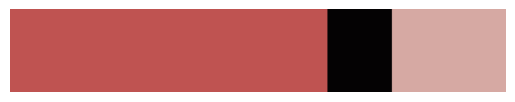

In [113]:
#get dominant color from Background.jpg
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
#import centroid_histogram, plot_colors
def centroid_histogram(clt):
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    hist = hist.astype("float")
    hist /= hist.sum()
    return hist
def plot_colors(hist, centroids):
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0
    for (percent, color) in zip(hist, centroids):
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50), color.astype("uint8").tolist(), -1)
        startX = endX
    return bar
image = cv2.imread('Background.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.reshape((image.shape[0] * image.shape[1], 3))
clt = KMeans(n_clusters = 3)
clt.fit(image)
hist = centroid_histogram(clt)
bar = plot_colors(hist, clt.cluster_centers_)
plt.figure()
plt.axis("off")
plt.imshow(bar)
plt.show()

In [114]:
#save the dominant color to a file
dominant_color = clt.cluster_centers_[np.argmax(hist)]
np.savetxt('dominant_color.txt', dominant_color, delimiter=',', fmt='%d')

In [115]:
# Display the result
print(f"Dominant background color: {dominant_color}")
cv2.imshow('Dominant Color', np.full((100, 100, 3), dominant_color, dtype=np.uint8))

Dominant background color: [     191.98      83.667      81.542]


### Loading the resnet model

In [116]:
# Load a pre-trained ResNet model for feature extraction
resnet = models.resnet50(pretrained=True)
resnet.eval()

c:\Users\Yug Dedhia\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Yug Dedhia\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Getting feature vectors for the images

In [117]:
# Define the image transformations
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [118]:
# Function to extract feature vector from an image
def get_feature_vector(image):
    # Preprocess the image
    img_tensor = preprocess(image)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    # Extract features
    with torch.no_grad():
        features = resnet(img_tensor)
    return features.numpy()

In [119]:
background_feature = get_feature_vector(background_pixels)

In [120]:
#there are 4 players in the image playing badminton. Now I have to get feature vectors of each player from the images of the players. The images of the players are in the folders two_players_bot and two_players_top.
# Load the images of the players
player1_image_path='two_players_bot/24082_86_142_128.jpg'
player2_image_path='two_players_bot/24082_91_117_125.jpg'
player3_image_path='two_players_top/24082_62_122_121.jpg'
player4_image_path='two_players_top/24082_87_119_124.jpg'


In [121]:
player1_image= cv2.imread(player1_image_path)
player2_image= cv2.imread(player2_image_path)
player3_image= cv2.imread(player3_image_path)
player4_image= cv2.imread(player4_image_path)

In [122]:
#get feature vectors of the players
player1_feature = get_feature_vector(player1_image)
player2_feature = get_feature_vector(player2_image)
player3_feature = get_feature_vector(player3_image)
player4_feature = get_feature_vector(player4_image)

In [123]:
player1_main_feature=get_feature_vector(cv2.imread('player_1_0.jpg'))
player2_main_feature=get_feature_vector(cv2.imread('player_1_1.jpg'))
player3_main_feature=get_feature_vector(cv2.imread('player_2_0.jpg'))
player4_main_feature=get_feature_vector(cv2.imread('player_2_1.jpg'))

In [124]:
#get cosine similarity between the feature vectors of the player1_feature and player1_main_feature
from sklearn.metrics.pairwise import cosine_similarity
x=cosine_similarity(player2_feature, player1_main_feature)
print(x)
y=cosine_similarity(player1_feature, player2_main_feature)
print(y)

[[    0.61268]]
[[    0.65413]]


### Classifying Players using cosine similarity

In [125]:
#compare the players based on the cosine similarity
def compare_players(player1_main_feature, player2_main_feature,player_feature,player_image,view,i):
    x=cosine_similarity(player1_main_feature, player_feature)
    y=cosine_similarity(player2_main_feature, player_feature)
    if x>y:
        cv2.imwrite(f'player1_{view}/{i}.jpg', player_image)
    else:
        cv2.imwrite(f'player2_{view}/{i}.jpg', player_image)

In [126]:
#get the images of the player from the folder two_players_bot and two_players_top using for loop
#compare the players using the compare_players function
import os
extraction_path='two_players_bot'
for i,image in enumerate(os.listdir(extraction_path)):
    player_image=cv2.imread(f'{extraction_path}/{image}')
    player_feature=get_feature_vector(player_image)
    player=compare_players(player1_main_feature, player2_main_feature,player_feature, player_image,'bottom',i)

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [127]:
#do the same for the folder two_players_top
extraction_path='two_players_top'
for i, image in enumerate(os.listdir(extraction_path)):
    player_image=cv2.imread(f'{extraction_path}/{image}')
    player_feature=get_feature_vector(player_image)
    player=compare_players(player3_main_feature,player4_main_feature,player_feature,player_image,'top',i)

### Removing the dominant color (background colour) from the images. And doing the same process to evaluate the betterness

In [128]:
def remove_dominant_color(image, dominant_color, tolerance=30):
    """
    Remove the dominant color from the image and replace it with white.

    :param image: Input image as a NumPy array.
    :param dominant_color: Tuple (R, G, B) representing the dominant color to be removed.
    :param tolerance: Tolerance level for color matching (default is 30).
    :return: Image with the dominant color replaced by white.
    """
    
    # Convert the image to RGB (OpenCV loads images in BGR format by default)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Define the lower and upper bounds for the dominant color with tolerance
    lower_bound = np.array(dominant_color) - tolerance
    upper_bound = np.array(dominant_color) + tolerance
    
    # Clip the values to stay within [0, 255]
    lower_bound = np.clip(lower_bound, 0, 255)
    upper_bound = np.clip(upper_bound, 0, 255)
    
    # Create a mask where the dominant color range is True
    mask = cv2.inRange(image_rgb, lower_bound, upper_bound)
    
    # Invert the mask to get the foreground (player) area
    mask_inv = cv2.bitwise_not(mask)
    
    # Use the inverted mask to extract the player from the image
    player_only = cv2.bitwise_and(image, image, mask=mask_inv)
    
    # Create a white background
    white_background = np.ones_like(image, dtype=np.uint8) * 255
    
    # Combine the player area with the white background
    result_image = np.where(mask_inv[:, :, np.newaxis] == 255, player_only, white_background)
    
    return result_image

In [129]:
removed=remove_dominant_color(cv2.imread('player_2_1.jpg'), dominant_color)
cv2.imwrite('player_2_1_removed.jpg', removed)
removed=remove_dominant_color(cv2.imread('player_2_0.jpg'), dominant_color)
cv2.imwrite('player_2_0_removed.jpg', removed)
removed=remove_dominant_color(cv2.imread('player_1_1.jpg'), dominant_color)
cv2.imwrite('player_1_1_removed.jpg', removed)
removed=remove_dominant_color(cv2.imread('player_1_0.jpg'), dominant_color)
cv2.imwrite('player_1_0_removed.jpg', removed)

True

In [130]:
#get the feature vectors of the players after removing the dominant color
player1_main_feature=get_feature_vector(cv2.imread('player_1_0_removed.jpg'))
player2_main_feature=get_feature_vector(cv2.imread('player_1_1_removed.jpg'))
player3_main_feature=get_feature_vector(cv2.imread('player_2_0_removed.jpg'))
player4_main_feature=get_feature_vector(cv2.imread('player_2_1_removed.jpg'))

In [131]:
#remove background from the player images with the dominant color from the folder two_players_bot
extraction_path='two_players_bot'
for i,image in enumerate(os.listdir(extraction_path)):
    player_image=cv2.imread(f'{extraction_path}/{image}')
    removed=remove_dominant_color(player_image, dominant_color)
    #save in the folder two_players_bot_removed
    cv2.imwrite(f'two_players_bot_removed/{i}.jpg', removed)

In [132]:
#remove background from the player images with the dominant color from the folder two_players_top
extraction_path='two_players_top'
for i,image in enumerate(os.listdir(extraction_path)):
    player_image=cv2.imread(f'{extraction_path}/{image}')
    removed=remove_dominant_color(player_image, dominant_color)
    #save in the folder two_players_top_removed
    cv2.imwrite(f'two_players_top_removed/{i}.jpg', removed)

In [133]:
#now compare the players based on the cosine similarity
def compare_players_new(player1_main_feature, player2_main_feature,player_feature,player_image,view,i):
    x=cosine_similarity(player1_main_feature, player_feature)
    y=cosine_similarity(player2_main_feature, player_feature)
    if x>y:
        cv2.imwrite(f'player1_new_{view}/{i}.jpg', player_image)
    else:
        cv2.imwrite(f'player2_new_{view}/{i}.jpg', player_image)

In [134]:
extraction_path='two_players_bot_removed'
for i,image in enumerate(os.listdir(extraction_path)):
    player_image=cv2.imread(f'{extraction_path}/{image}')
    player_feature=get_feature_vector(player_image)
    player=compare_players_new(player1_main_feature, player2_main_feature,player_feature, player_image,'bottom',i)

In [135]:
extraction_path='two_players_top_removed'
for i, image in enumerate(os.listdir(extraction_path)):
    player_image=cv2.imread(f'{extraction_path}/{image}')
    player_feature=get_feature_vector(player_image)
    player=compare_players_new(player3_main_feature,player4_main_feature,player_feature,player_image,'top',i)